In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T114900Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D866c335b1ba854223f2624b50dd8d5959de98bfbe23d1ec83fa85b63e4d01108495b611954e93a318dcf978e6f6ff9395ca37bbe01017cbe0d5be25e60b4e3f2b9da23a458c850210750b08e0412028e3ba8da1f03df657cb89d5c82f34d69ea817bec3373875a46982a96c0509a54c17962f1bff17b5c823cc4394c264fbab5f537b1967c87a597cf5116c7725d87996cf1db006dcf58f7b9f587754b69667fc1726c39b52904c0722e9490ed34c4a7d347c29c51eaf059a7fae0bec3f197b441a6a26e74147ebf06903ec5169eca91576c7af9c5c0ccfb89bbc0fd9567b5e16f0b154a626c3eb4fc58feea5756fc3e0d3f09359b871b65c9ddaf7fe89864a8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


In [2]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('check')

check


# Data Preprocessing



**store the data into data frames**

In [3]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
1,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
2,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
3,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
4,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor


In [5]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor


Split dataframe into train, valid, and test (we see that data splitted into train and test)


In [7]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

Create image data generator


In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


Show sample from train data


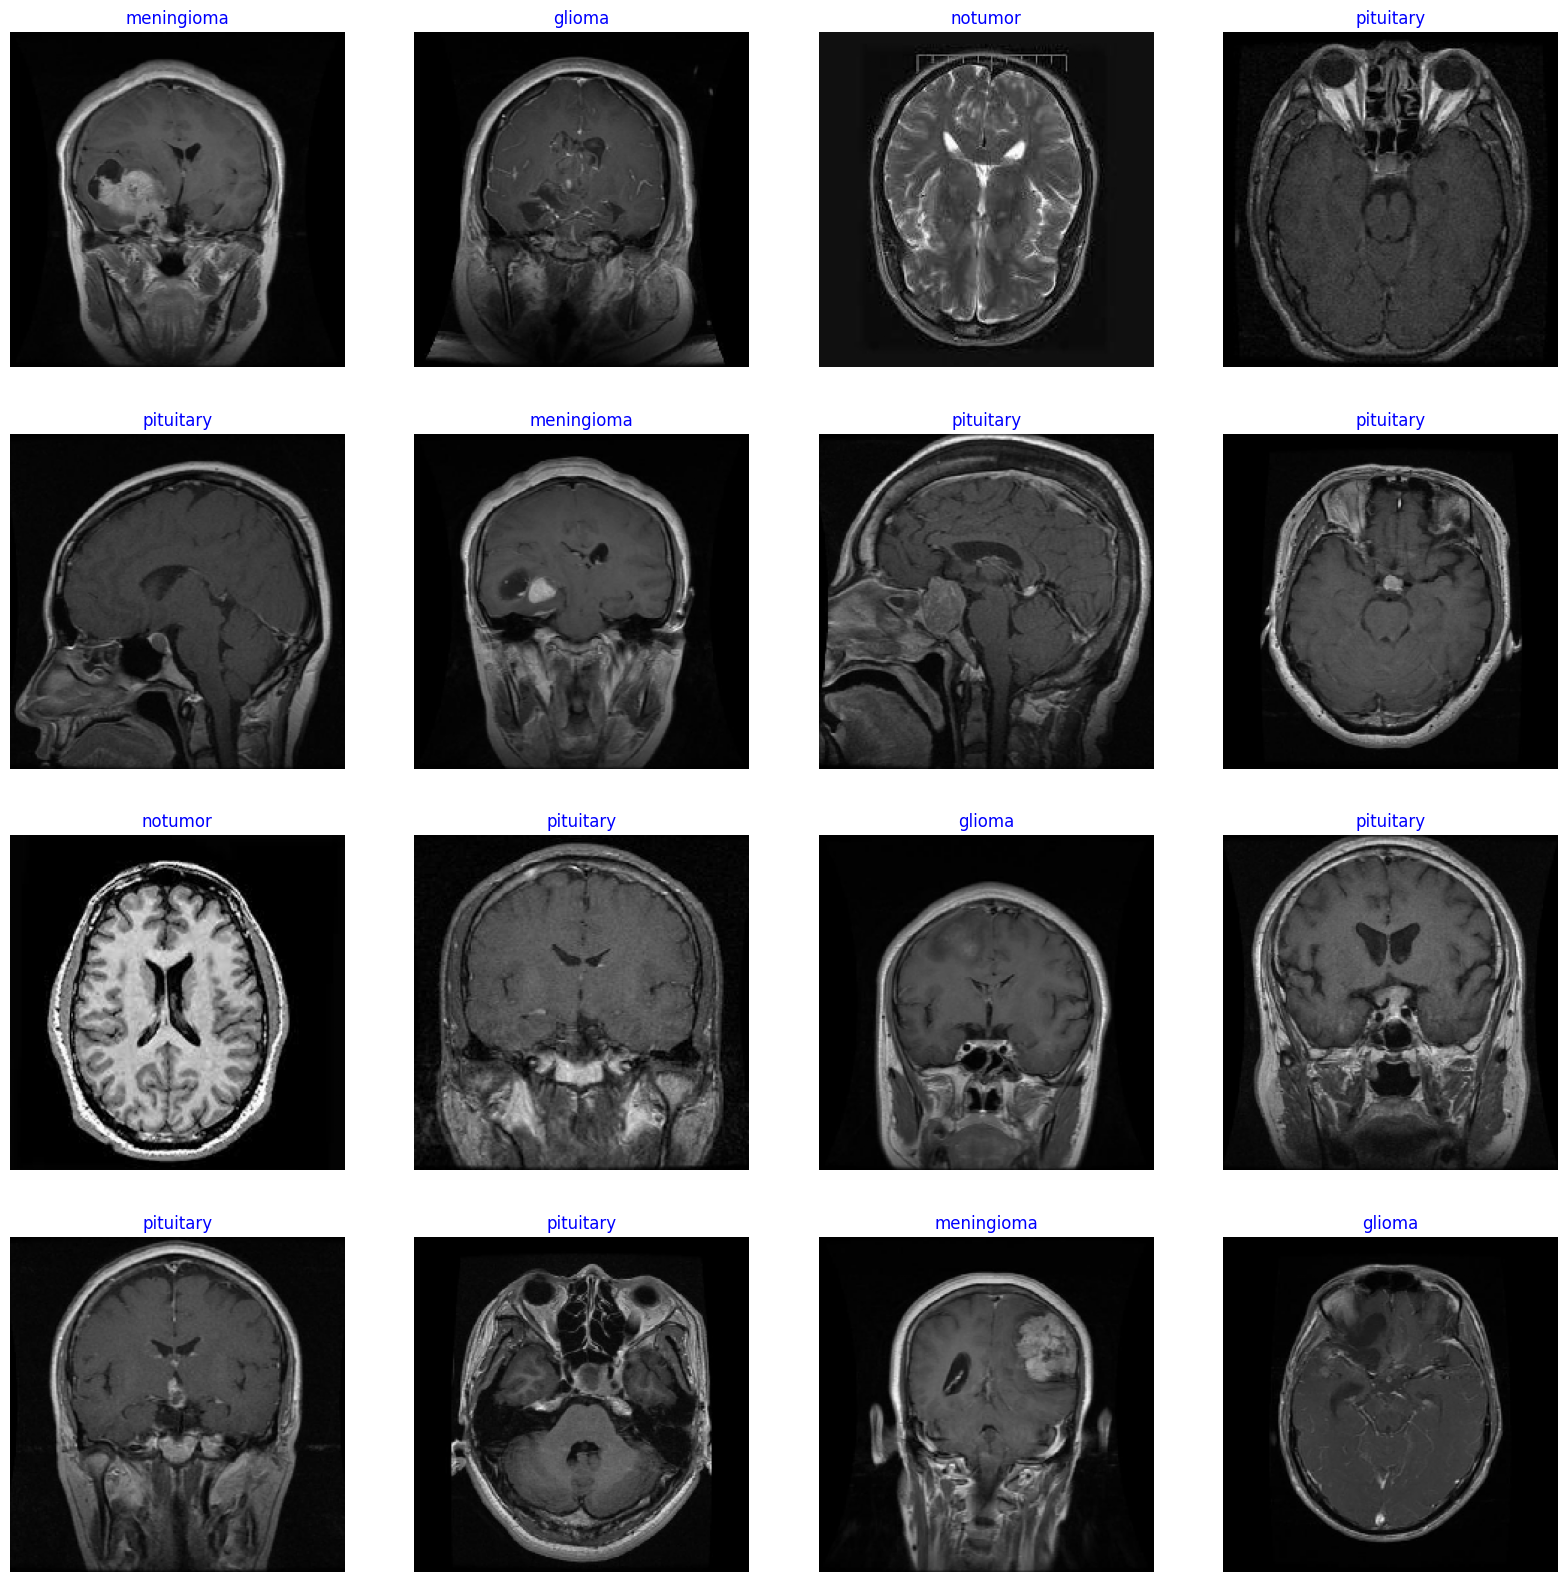

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# now lets belt our Model Structure¶


In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4
model =Sequential ([
    Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=img_shape),
    Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256,activation="relu"),

    Dense(128,activation="relu"),
    Dense(4,activation="softmax")
])
model.compile (Adamax(learning_rate=0.001),loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                   

# lets train data in our model

In [11]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 [==============================] - 92s 202ms/step - loss: 1.6859 - accuracy: 0.5518 - val_loss: 0.9516 - val_accuracy: 0.6336
Epoch 2/10
357/357 [==============================] - 67s 189ms/step - loss: 0.5979 - accuracy: 0.7607 - val_loss: 0.5497 - val_accuracy: 0.7985
Epoch 3/10
357/357 [==============================] - 68s 189ms/step - loss: 0.4263 - accuracy: 0.8484 - val_loss: 0.5184 - val_accuracy: 0.7908
Epoch 4/10
357/357 [==============================] - 68s 189ms/step - loss: 0.3246 - accuracy: 0.8783 - val_loss: 0.3909 - val_accuracy: 0.8397
Epoch 5/10
357/357 [==============================] - 68s 189ms/step - loss: 0.2785 - accuracy: 0.9013 - val_loss: 0.4523 - val_accuracy: 0.8336
Epoch 6/10
357/357 [==============================] - 68s 189ms/step - loss: 0.2356 - accuracy: 0.9137 - val_loss: 0.3476 - val_accuracy: 0.8672
Epoch 7/10
357/357 [==============================] - 68s 189ms/step - loss: 0.1936 - accuracy: 0.9291 - val_loss: 0.2291 - val_ac

# model performance

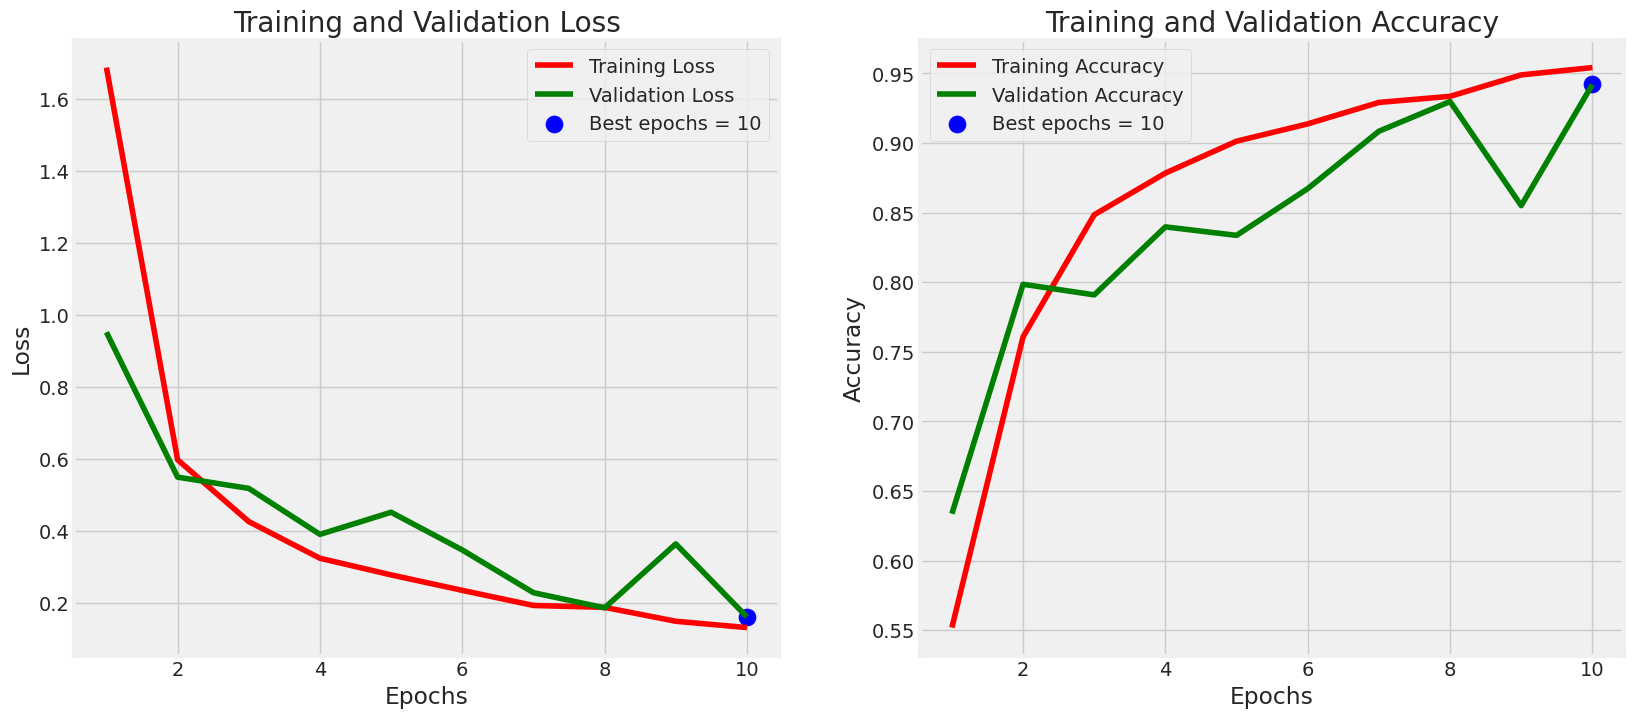

In [12]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();


# model evaluation

In [13]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 56ms/step - loss: 0.1744 - accuracy: 0.9414
Train Loss:  0.05063851922750473
Train Accuracy:  0.98828125
--------------------
Validation Loss:  0.1911948025226593
Validation Accuracy:  0.92578125
--------------------
Test Loss:  0.174429789185524
Test Accuracy:  0.94140625


# model predection

In [14]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 [==============================] - 2s 52ms/step


In [15]:
preds


array([[9.9868757e-01, 7.2856725e-04, 5.8380311e-04, 5.2269167e-10],
       [2.7593378e-05, 4.6613440e-01, 1.4684773e-02, 5.1915324e-01],
       [6.8421461e-05, 3.0496750e-02, 9.6937054e-01, 6.4238811e-05],
       ...,
       [5.2593485e-12, 1.5214061e-09, 1.0000000e+00, 2.5503246e-14],
       [1.6397606e-01, 8.3333021e-01, 2.5867822e-03, 1.0697905e-04],
       [9.6399599e-06, 6.0055166e-04, 7.1262337e-05, 9.9931860e-01]],
      dtype=float32)

# confusion matrix

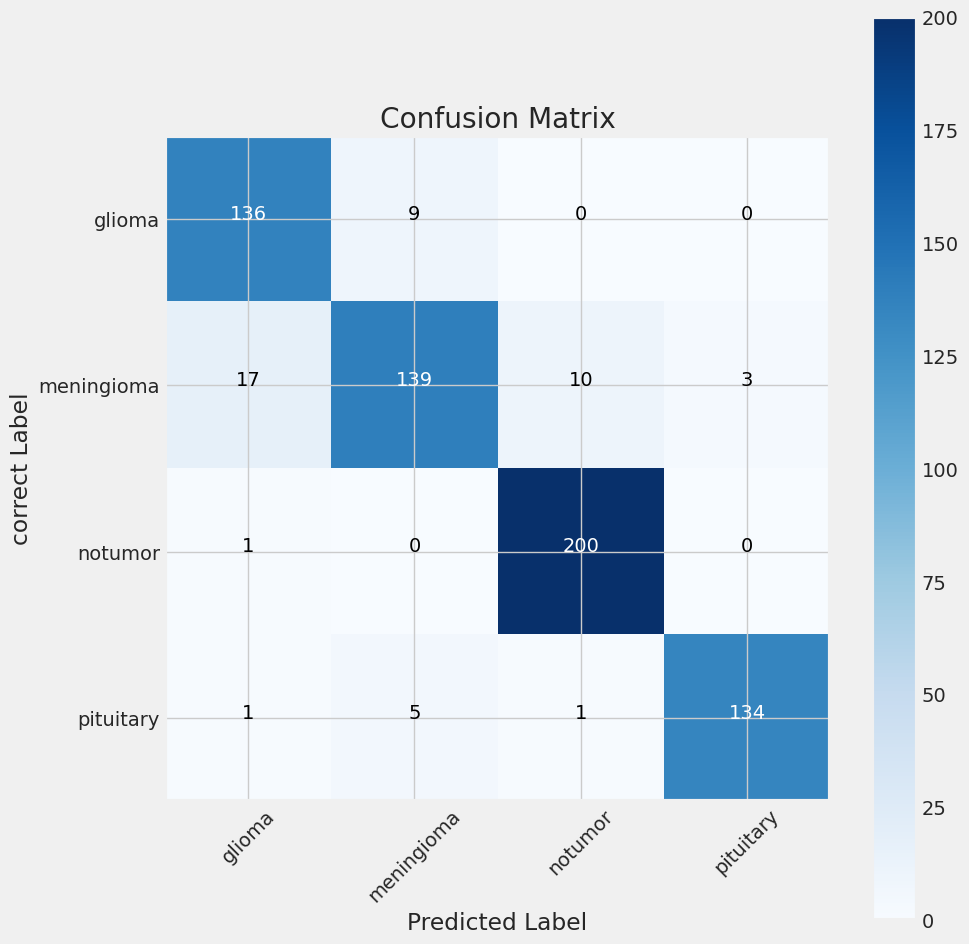

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('correct Label')
plt.xlabel('Predicted Label')

plt.show()

# classification report

In [17]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.88      0.94      0.91       145
  meningioma       0.91      0.82      0.86       169
     notumor       0.95      1.00      0.97       201
   pituitary       0.98      0.95      0.96       141

    accuracy                           0.93       656
   macro avg       0.93      0.93      0.93       656
weighted avg       0.93      0.93      0.93       656



In [20]:
import joblib

# Assuming your model object is called model
# Replace 'model' with the name of your actual model object
joblib.dump(model, 'brain_tumor_prediction.sav')

['brain_tumor_prediction.sav']